<a href="https://colab.research.google.com/github/Prakartt/Customer-Segmentation-and-Stock-market-prediction-for-portfolio-generation-/blob/main/BAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h2>PART 1. Data Pre-processing</h2>

In [ ]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import TensorBoard
from  tensorflow.keras.callbacks import ReduceLROnPlateau
from  tensorflow.keras.callbacks import EarlyStopping

<h3>Step #1. Read data</h3>

In [ ]:
# Importing Training Set
dataset_train = pd.read_csv('/content/BAC.csv')
df=dataset_train
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (12447, 7)
All timestamps == 12447
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [ ]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (12447, 5).


array([[ 4.625   ,  4.625   ,  4.625   ,  4.625   ,  1.651409],
       [ 4.640625,  4.640625,  4.640625,  4.640625,  1.65699 ],
       [ 4.625   ,  4.625   ,  4.625   ,  4.625   ,  1.651409],
       ...,
       [32.380001, 32.41    , 31.26    , 32.080002, 32.080002],
       [31.25    , 32.77    , 31.23    , 32.310001, 32.310001],
       [32.419998, 32.599998, 31.91    , 32.349998, 32.349998]])

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.80201145],
       [-0.80098685],
       [-0.80201145],
       ...,
       [ 1.0180038 ],
       [ 0.94390475],
       [ 1.02062657]])

In [ ]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 750   # Number of days we want top predict into the future
n_past =  600    # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (11098, 600, 4).
y_train shape == (11098, 1).


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [ ]:
# Import Libraries and packages from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

<h3>Step #4. Start training</h3>

In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=10, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 0.4209
Epoch 1: val_loss improved from inf to 0.15717, saving model to weights.h5
35/35 [==============================] - 63s 2s/step - loss: 0.4209 - val_loss: 0.1572 - lr: 0.0100
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.3509
Epoch 2: val_loss did not improve from 0.15717
35/35 [==============================] - 55s 2s/step - loss: 0.3509 - val_loss: 0.1630 - lr: 0.0100
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.2592
Epoch 3: val_loss improved from 0.15717 to 0.15269, saving model to weights.h5
35/35 [==============================] - 55s 2s/step - loss: 0.2592 - val_loss: 0.1527 - lr: 0.0100
Epoch 4/10
35/35 [==============================] - ETA: 0s - loss: 0.2532
Epoch 4: val_loss did not improve from 0.15269
35/35 [==============================] - 56s 2s/step - loss: 0.2532 - val_loss: 0.2166 - lr: 0.0100
Epoch 5/10
35/35 [==============================] - 

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<h3>Step #5. Make predictions for future dates</h3>

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

#PREDICTION_TRAIN['Open']=PREDICTION_TRAIN['Open']
PREDICTIONS_FUTURE['Open']=PREDICTIONS_FUTURE['Open']+12

PREDICTIONS_FUTURE

,Open
2022-06-27,33.580162
2022-06-28,33.595959
2022-06-29,33.596786
2022-06-30,33.618092
2022-07-01,33.630836
...,...
2024-07-11,34.709557
2024-07-12,34.742847
2024-07-13,34.739189
2024-07-14,34.735847


<h3>Step #6. Visualize the Predictions</h3>

In [ ]:
PREDICTIONS_FUTURE.to_excel("PredictionsF_BAC.xlsx",sheet_name='Sheet_name_1')
PREDICTIONS_FUTURE

,Open
2022-06-27,33.580162
2022-06-28,33.595959
2022-06-29,33.596786
2022-06-30,33.618092
2022-07-01,33.630836
...,...
2024-07-11,34.709557
2024-07-12,34.742847
2024-07-13,34.739189
2024-07-14,34.735847


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 2022-06-27 to 2024-07-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    750 non-null    float32
dtypes: float32(1)
memory usage: 8.8 KB


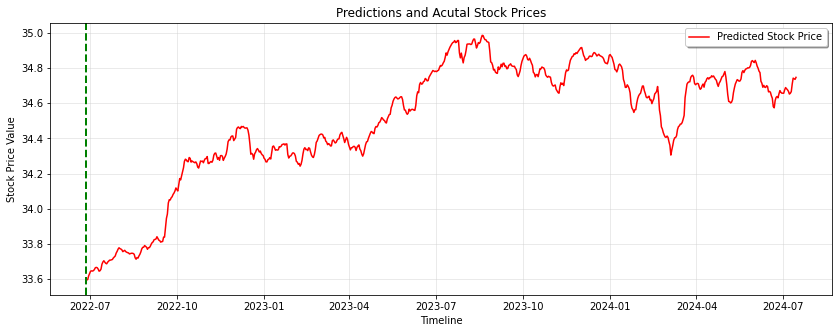

In [ ]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5


PREDICTIONS_FUTURE.info()

# Plot parameters
START_DATE_FOR_PLOTTING = '2014-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
#plt.plot(DFval['Date'],DFval['Open'])
#plt.plot(df['Date'],df['Close'])
#plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
#plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)

plt.show()

In [ ]:
results = np.std(df['Open'])
print(results)


15.249872817781625


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)